In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [4]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled
torch.backends.cudnn.benchmark=True

In [7]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [8]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [9]:
im_size = 299

In [10]:
train_tfms = TransformList([
        RandomScale(im_size, 1.1),
        RandomCrop(im_size),
        RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
        Scale(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
batch_size = 8
data = ImageData.from_csv(DATA_PATH, MULTICLASS_CSV_PATH, batch_size, train_tfms, val_tfms)
num_classes = 8

In [12]:
# next(iter(data['valid']))

In [13]:
model_ft = models.resnet34(pretrained=True)
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=.5),
    nn.Linear(num_ftrs, num_classes),
    nn.Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
optim_fn = optim.Adam

In [15]:
sess = Session(model_ft, criterion, optim_fn, [*[1e-3] * 9, 1e-2])

In [16]:
sess.unfreeze() 

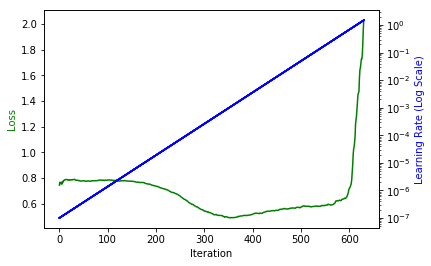

In [17]:
lr_find(sess, data['train'], start_lr=1e-7)

In [18]:
sess.set_lr(3e-4)

In [19]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 3)

RuntimeError: cuda runtime error (2) : out of memory at d:\pytorch\pytorch\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
for detail in accuracy.confusion:
    print(detail)

In [ ]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

In [ ]:
sess.save('TrainLayer1')

In [ ]:
sess.load('TrainLayer1')

In [ ]:
sess.unfreeze()

In [ ]:
lr_find(sess, data['train'], 
        start_lr=[*[1e-6 / 1000] * 5, *[1e-6 / 100] * 4, 1e-6], 
        end_lr=[*[10 / 1000] * 5, *[10 / 100] * 4, 10])

In [ ]:
sess.set_lr([*[1e-4 / 1000] * 5, *[1e-4 / 100] * 4, 1e-4])

In [ ]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 7)

In [ ]:
for detail in accuracy.confusion:
    print(detail)

In [ ]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

In [ ]:
lr_scheduler.plot()

In [ ]:
sess.save('FullTrain')

In [ ]:
sess.load('FullTrain')

In [ ]:
sess.train(schedule, 8)

In [ ]:
sess.save('FullTrain2')

In [ ]:
sess.load('FullTrain2')

In [ ]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

In [ ]:
for detail in accuracy.confusion:
    print(detail)